### Modelling

Target variable -  categorical 

models - Logistic regression , tree-based models 

In [76]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('waze_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


> there are 700 missing values in the target variable

In [4]:
# drop ID column
df.drop(['ID'],axis=1,inplace=True)

In [6]:
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

In [5]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


> The class is not highly imbalanced.

> The following columns seem to have outliers 'sessions', 'drives', 'total_sessions', 'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives' as all of these columns have max values that are multiple standard deviations above the 75th percentile.

#### Feature Engineering

In EDA we have seen that km_per_driving_day , drives_per_driving_day are correlated with the churn rate. If we include both features there will be high multicolinearity so lets include only one.

In [7]:
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Note that some values are infinite. This is the result of there being values of zero in the driving_days column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

>Convert these values from infinity to zero. You can use np.inf to refer to a value of infinity.

In [9]:
df.loc[df['km_per_driving_day']==np.inf,'km_per_driving_day']=0
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

Create a new, binary feature called professional_driver that is a 1 for users who had 60 or more drives and drove on 15+ days in the last month.

>Note: The objective is to create a new feature that separates professional drivers from other drivers

In [10]:
df['professional_driver']=np.where((df['drives']>=60)&(df['driving_days']>=15),1,0)
df['professional_driver'].value_counts(normalize=True)

professional_driver
0    0.827055
1    0.172945
Name: proportion, dtype: float64

In [12]:
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

> The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

### Preparing data for modeling

In [13]:
# 1. drop missing values
df.dropna(subset=['label'],inplace=True)

In [14]:
# 2. Imputing Outliers 
# impute outliers with 95th percentile values
cols = ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']
for col in cols:
    threshold = df[col].quantile(0.95)
    df.loc[df[col]>threshold,col]=threshold
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


In [19]:
# 3. encoding categorical variables label , device
df['label2']=np.where(df['label']=='churned',1,0)
df['device2']=np.where(df['device']=='Android',0,1)

#### checking model assumptions

The following are the assumptions for logistic regression:

>Independent observations (This refers to how the data was collected.)

>No extreme outliers

>Little to no multicollinearity among X predictors

>Linear relationship between X and the logit of y

For the first assumption, you can assume that observations are independent for this project.
The second assumption has already been addressed.
The last assumption will be verified after modeling.

In [24]:
corr= df[df.describe().columns].corr(method='pearson')
corr

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2,device2
sessions,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911,0.012704
drives,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865,0.011684
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254433,0.024568,0.012138
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263,-0.011299
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322,-0.001316
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032,-0.000275
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.000904,0.019767,-0.002091
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.012128,0.040407,-0.007709
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851,-0.010221
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009425,0.947687,1.000000,-0.407917,0.469776,-0.294259,-0.003859


<Axes: >

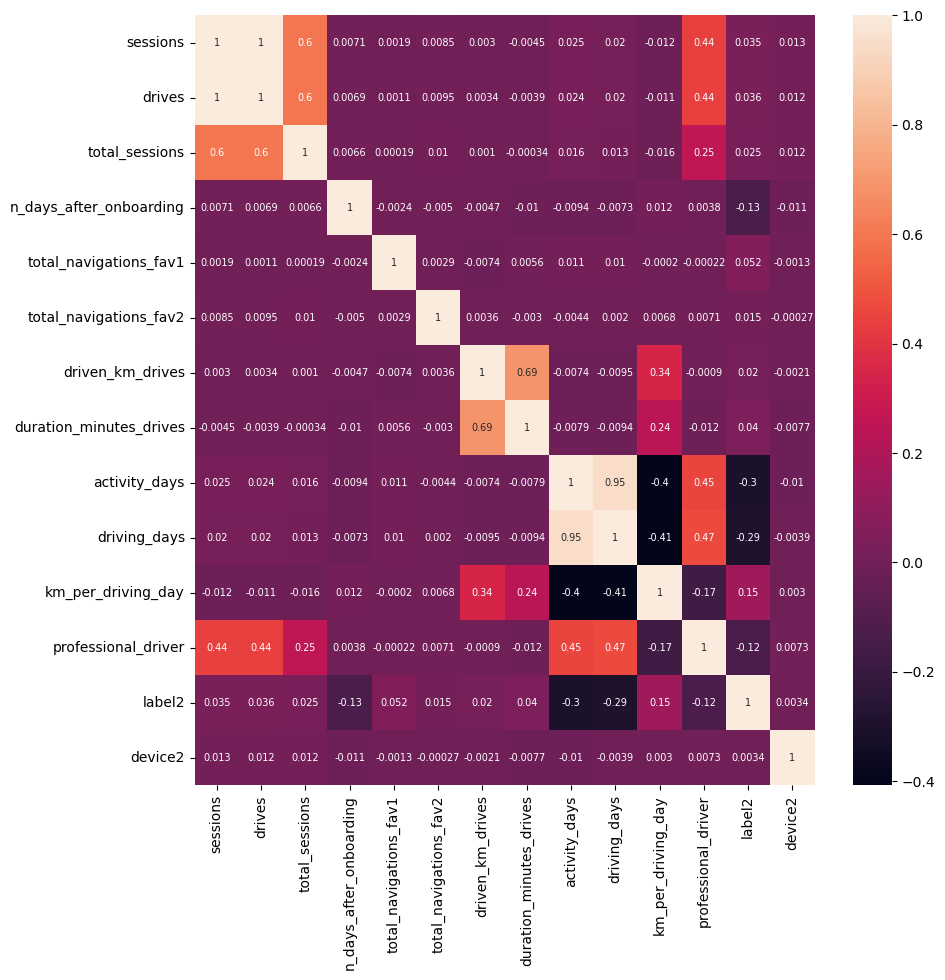

In [31]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True,annot_kws={'size':7})

In [60]:
corr_pairs = corr.unstack()
sorted_corr_pairs = corr_pairs[(corr_pairs!=1.0)].abs().sort_values(ascending=False)
filtered_corr_pairs = sorted_corr_pairs.reset_index().drop_duplicates(subset=[0],keep='first')
filtered_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
filtered_corr_pairs[filtered_corr_pairs['Correlation']>0.1]

,Variable 1,Variable 2,Correlation
0,sessions,drives,0.996942
2,driving_days,activity_days,0.947687
4,driven_km_drives,duration_minutes_drives,0.690515
6,sessions,total_sessions,0.597189
8,drives,total_sessions,0.595285
10,professional_driver,driving_days,0.469776
12,professional_driver,activity_days,0.453825
14,professional_driver,drives,0.444425
16,sessions,professional_driver,0.443654
18,driving_days,km_per_driving_day,0.407917


Lets set the threshold for the multicolinearity here to 0.7. 
 (sessions	,drives) ,(driving_days	, activity_days) have high multicolinearity remove one variable from each pair.

#### train_test_split

In [61]:
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])
y = df['label2']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [62]:
model = LogisticRegression(penalty='none', max_iter=400)

model.fit(X_train, y_train)

/Users/amruthakaruturi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(max_iter=400, penalty='none')

In [64]:
pd.Series(model.coef_[0], index=X.columns), model.intercept_

(drives                     0.001913
 total_sessions             0.000327
 n_days_after_onboarding   -0.000406
 total_navigations_fav1     0.001232
 total_navigations_fav2     0.000931
 driven_km_drives          -0.000015
 duration_minutes_drives    0.000109
 activity_days             -0.106032
 km_per_driving_day         0.000018
 professional_driver       -0.001529
 device2                   -0.001041
 dtype: float64,
 array([-0.00170675]))

**Check final assumption**

Verify the linear relationship between X and the estimated log odds (known as logits) by making a regplot.

In [65]:
# Get the predicted probabilities of the training data
#  The first column is the probability of the user not churning,
# and the second column is the probability of the user churning.
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93963503, 0.06036497],
       [0.61967273, 0.38032727],
       [0.76463133, 0.23536867],
       ...,
       [0.91909624, 0.08090376],
       [0.85092145, 0.14907855],
       [0.93516276, 0.06483724]])

In [66]:
logit_data = X_train.copy()
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

In [68]:
cols= logit_data.columns[:-1]
cols

Index(['drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'km_per_driving_day',
       'professional_driver', 'device2'],
      dtype='object')

In [70]:
1//2

0

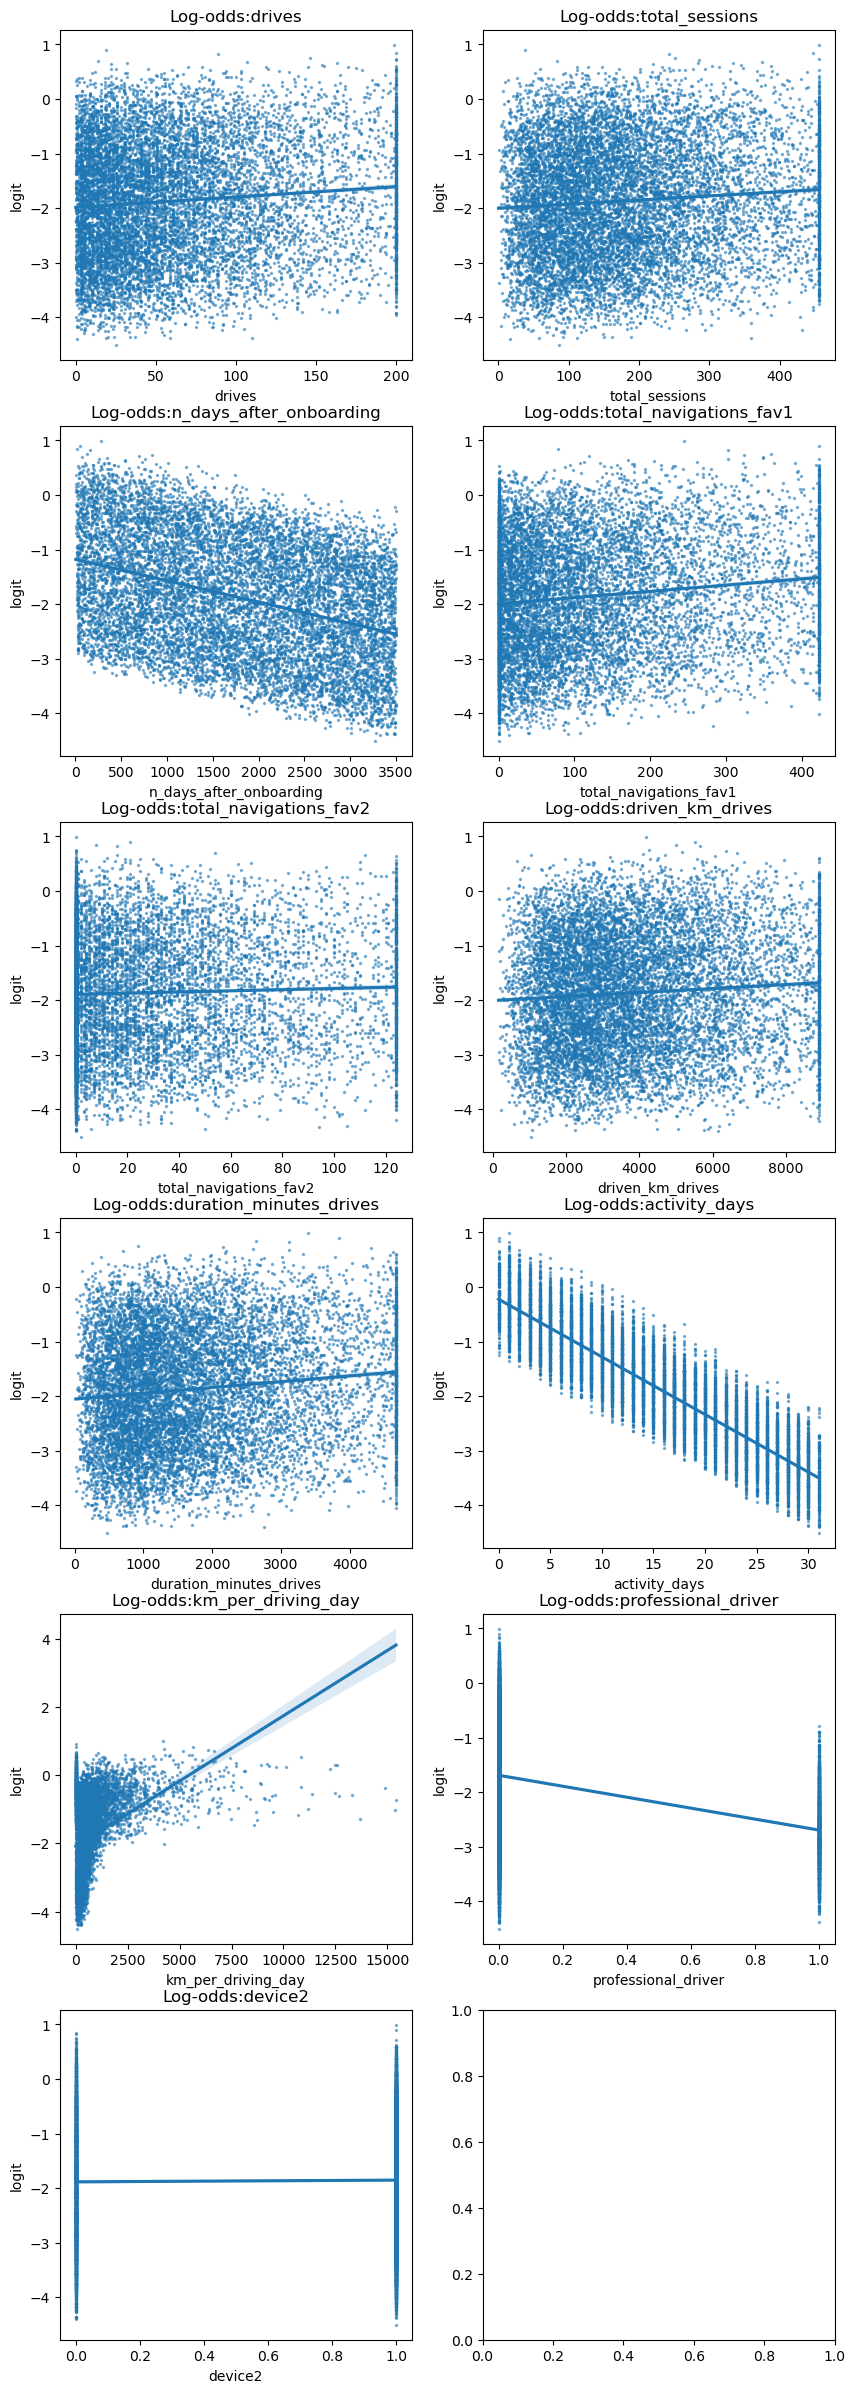

In [72]:
fig,ax =plt.subplots(nrows=6,ncols=2,figsize=(10,30))
i=0
for col in cols:
    sns.regplot(x=col,y='logit',data=logit_data,scatter_kws={'s': 2, 'alpha': 0.5},ax=ax[i//2][i%2])
    ax[i//2][i%2].set_title(f'Log-odds:{col}')
    i=i+1

#### Evaluation on test data

In [73]:
y_preds = model.predict(X_test)
model.score(X_test, y_test) # returns accuracy_score

0.8237762237762237

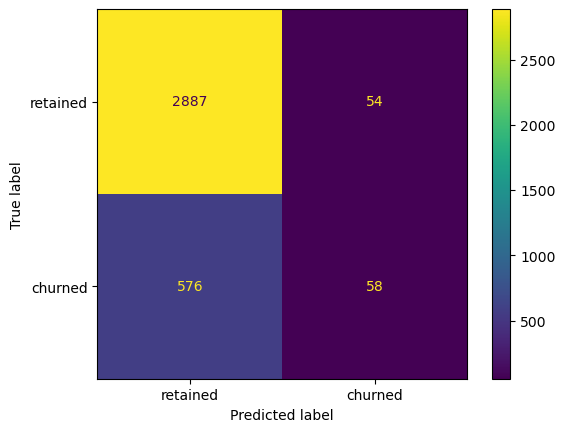

In [74]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

In [77]:
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



The model has mediocre precision and very low recall, which means that it makes a lot of false negative predictions and fails to capture users who will churn.

In [78]:
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance

[('drives', 0.0019133449076844376),
 ('total_navigations_fav1', 0.0012317493159279852),
 ('total_navigations_fav2', 0.0009314681963070406),
 ('total_sessions', 0.000327099784186181),
 ('duration_minutes_drives', 0.00010909434568921785),
 ('km_per_driving_day', 1.8224382962323105e-05),
 ('driven_km_drives', -1.4861756138545932e-05),
 ('n_days_after_onboarding', -0.00040647828514673846),
 ('device2', -0.0010412154599555698),
 ('professional_driver', -0.0015285012379747795),
 ('activity_days', -0.10603175954711298)]

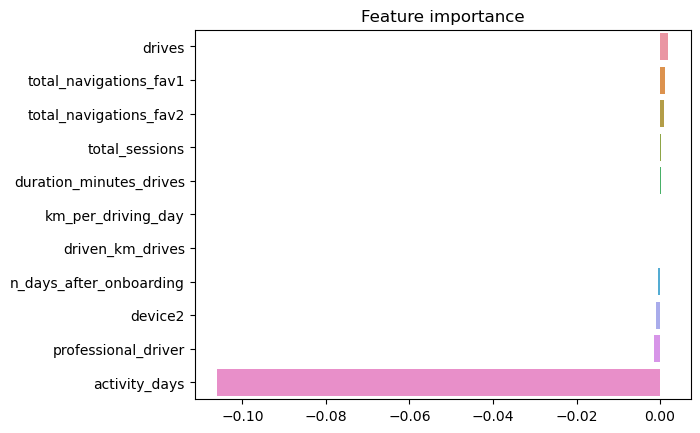

In [79]:
import seaborn as sns
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');